In [1]:
from matplotlib.pyplot import axes
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"


def prepare_data(
    dataset,
    num_imgs=10,
    preprocess_sensory=True,
    noise_level="medium",
    use_fix=False,
):
    import torch
    import random

    data = dataset.data
    # print(num_imgs)
    # print(data.shape)
    data = data.reshape(data.shape[0], -1)
    # print(data.shape)
    data = torch.tensor(data[:num_imgs]).float().to(device)
    # print(data.shape)

    # data = random.sample(dataset.data.flatten(1).float().to("cpu"), num_imgs)
    if preprocess_sensory:
        if use_fix:
            for i in range(len(data)):
                data[i] = (data[i] - data[i].mean()) / data[i].std()
        else:
            data = (data - data.mean()) / data.std()
    # noissing the data
    if noise_level == "none":
        return data, data
    elif noise_level == "low":
        random_noise = torch.zeros_like(data).uniform_(-1, 1)
    elif noise_level == "medium":
        random_noise = torch.zeros_like(data).uniform_(-1.25, 1.25)
    elif noise_level == "high":
        random_noise = torch.zeros_like(data).uniform_(-1.5, 1.5)
    noisy_data = data + random_noise

    return data, noisy_data

In [2]:
import torchvision
from torchvision import transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

Images seen 10
Accuracy on whole dataset: 0.0993
Accuracy on seen images: 0.3
Accuracy per image: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

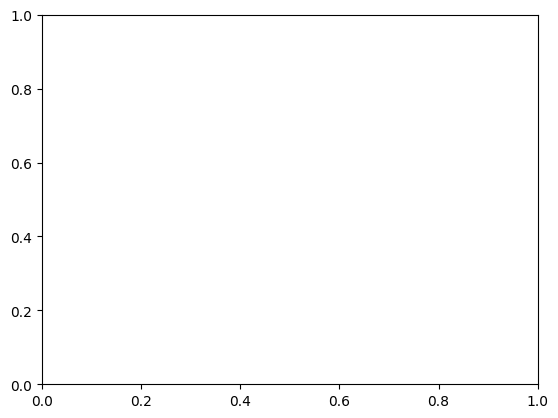

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

accuracy_over_num_images = []
accuracy_seen_over_num_images = []
accuracy_per_image = np.zeros(10)
count = 0
graphing_interval = 10

input_size = dataset.data.flatten(1).shape[1]
hidden_layer_factor = 10
output_size = 10

stationary = True
if stationary:
    hidden_layer = (
        torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
    )  # logistic function this

    output_layer_weights = torch.zeros(output_size, input_size * hidden_layer_factor)
    inhibition_matrix = torch.eye(input_size * hidden_layer_factor, device=device) / (
        input_size * hidden_layer_factor
    )

    def update_output_layer(input, output, inhibition_matrix, weights):
        # (7840, 7840) x (7840, 1) / (1 + (1, 7840) x (7840, 7840) x (7840, 1)) = (7840, 1)
        b_k = (inhibition_matrix @ input) / (1 + input.T @ inhibition_matrix @ input)
        # print((inhibition_matrix @ input).shape)
        # print((input.T @ inhibition_matrix @ input).shape)
        # print(b_k.shape)

        # (7840, 7840) - (7840, 7840) x (7840, 1) x (1, 7840) = (7840, 7840)
        # or (7840, 7840) - (7840, 7840) * (1, 7840) x (7840, 1) = (7840, 7840)
        # inhibition_matrix = inhibition_matrix - inhibition_matrix @ input @ b_k.T
        # inhibition_matrix = inhibition_matrix - inhibition_matrix * (input @ b_k.T)
        inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
            input, b_k.T
        )
        # print("inhibition k-1", inhibition_matrix.shape)
        # print("input @ b_k.T", (input @ b_k.T).shape)
        # print(
        #     "inhibition method 1 (inhibition_matrix * input @ b_k.T)",
        #     (inhibition_matrix * (input @ b_k.T)).shape,
        # )
        # print(
        #     (inhibition_matrix - inhibition_matrix * (input @ b_k.T)).shape,
        # )
        # print(
        #     "inhibition method 2 (inhibition_matrix @ input @ b_k.T)",
        #     (inhibition_matrix @ input @ b_k.T).shape,
        # )
        # print(
        #     (inhibition_matrix - inhibition_matrix @ input @ b_k.T).shape,
        # )
        # print(
        #     "inhibition after method 3 (inhibition_matrix @ torch.outer(input, b_k.T))",
        #     (inhibition_matrix @ torch.outer(input, b_k.T)).shape,
        # )
        # print(
        #     (inhibition_matrix - inhibition_matrix @ torch.outer(input, b_k.T)).shape,
        # )
        # print("Inhibition matrix", inhibition_matrix)
        # print("Inhibition matrix 2", inhibition_matrix_2)

        # (10, 7840) + ((10, 1) - (10, 7840) x (7840, 1)) x (7840, 1) = (10, 7840)
        weight_update = torch.outer((output - weights @ input), b_k.T)
        # print(weight_update.shape)
        # print((output - weights @ input).shape)
        # print(b_k.T.shape)
        # weight_update_2 = (output - weights @ input).reshape(-1) @ b_k.reshape(
        # -1
        # )  # this is as written exactly in paper, but some torch shape stuff changes it to above
        # print("Weight upadte", weight_update)
        # print("Weight upadte 2", weight_update_2)
        return inhibition_matrix, weights + weight_update

else:
    hidden_layer = (
        torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
    )  # logistic function this

    output_layer_weights = torch.zeros(output_size, input_size * hidden_layer_factor)
    epsilon = 0.01
    inhibition_matrix = torch.eye(input_size * hidden_layer_factor, device=device) / (
        epsilon**2
    )
    # M = 10 * input_size * hidden_layer_factor

    def update_output_layer(input, output, inhibition_matrix, weights):
        b_k = (inhibition_matrix @ input) / (1 + input.T @ inhibition_matrix @ input)
        # ERROR VECTOR EK
        e_k = output - weights @ input

        # NORMALIZATION FACTOR
        E = ((e_k.T @ e_k) / input_size * hidden_layer_factor) / (
            1 + input.T @ inhibition_matrix @ input
        )
        # E = torch.abs(E)
        # L2Enorm = torch.linalg.norm(e_k, dim=1, ord=2)  # normalization?

        # GAMMA CALCULATION
        gamma = 1 / (1 + ((1 - torch.exp(-E)) / epsilon))

        inhibition_matrix = gamma * (
            inhibition_matrix
            - inhibition_matrix * input @ b_k.T
            + ((1 - torch.exp(-E)) / epsilon)
            * torch.eye(input_size * hidden_layer_factor, device=device)
        )
        weight_update = torch.outer((output - weights @ input), b_k.T)
        # weight_update = (
        #     output - weights @ input
        # ) @ b_k  # this is as written exactly in paper, but some torch shape stuff changes it to above
        print("Weight upadte", weight_update)
        return inhibition_matrix, weights + weight_update


shuffled_indices = torch.randperm(len(dataset))
dataset.data = dataset.data[shuffled_indices]
dataset.targets = dataset.targets[shuffled_indices]

for d in dataset:
    count += 1
    input, target = d
    input = input.to(device)
    one_hot_target = (
        torch.nn.functional.one_hot(torch.tensor(target), output_size)
        .float()
        .to(device)
    )
    # print("One Hot Target", one_hot_target, target)
    # print(input.shape)
    hidden_layer_output = hidden_layer @ input
    # logistic function for sigmoid activation
    hidden_layer_output = torch.sigmoid(hidden_layer_output)
    inhibition_matrix, output_layer_weights = update_output_layer(
        hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
    )

    # print("Weights", output_layer_weights)
    # print("Max weight", torch.max(output_layer_weights))
    # print("Min weight", torch.min(output_layer_weights))

    # inhibition_matrix, output_layer_weights = update_output_layer_non_stationary(
    #     hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
    # )

    # test accuracy on whole dataset
    if count % graphing_interval == 0:
        print("Images seen", count)
        hidden_layer_output = (
            hidden_layer @ dataset.data.flatten(1).float().to(device).T
        )
        hidden_layer_output = torch.sigmoid(hidden_layer_output)
        output = output_layer_weights @ hidden_layer_output
        # print(output)
        # print(
        #     "max of the output (should be less than 1 if working properly)",
        #     torch.max(output),
        # )
        output = torch.argmax(output, dim=0)
        correct = (output == dataset.targets).sum().item()
        accuracy = correct / len(dataset)
        correct_on_seen = (output[:count] == dataset.targets[:count]).sum().item()
        accuracy_on_seen = correct_on_seen / count
        accuracy_over_num_images.append(accuracy)
        accuracy_seen_over_num_images.append(accuracy_on_seen)
        for i in range(output_size):
            targets = dataset.targets == i
            # print(targets)
            correct = (output[targets] == i).sum().item()
            accuracy_per_image[i] = correct / len(dataset.data[targets])

        print(f"Accuracy on whole dataset: {accuracy}")
        print(f"Accuracy on seen images: {accuracy_on_seen}")
        print(f"Accuracy per image: {accuracy_per_image}")
        plt.plot(
            np.linspace(0, count, len(accuracy_over_num_images)),
            accuracy_over_num_images,
        )
        plt.xlabel("Number of images trained")
        plt.ylabel("Accuracy")
        plt.title("Accuracy on all of MNIST")
        plt.show()
        plt.plot(
            np.linspace(0, count, len(accuracy_seen_over_num_images)),
            accuracy_seen_over_num_images,
        )
        plt.xlabel("Number of images trained")
        plt.ylabel("Accuracy")
        plt.title("Accuracy on seen images (training set)")
        plt.show()
        plt.plot(accuracy_per_image)
        plt.xlabel("Number")
        plt.ylabel("Accuracy Per Number")
        plt.title("Accuracy per number")
        plt.show()